In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import Input, Model
from keras import layers, regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping
#import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn import metrics
import warnings
#import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [2]:
train_data = pd.read_csv('E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/material_df.csv')
train_data['sale_qty'] = train_data['bill_qty_sku'].astype(np.int64)
train_data['material'] = train_data['material'].astype(np.int64)
train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data.drop(['Unnamed: 0', 'bill_qty_sku'], axis=1)
train_data.info()
train_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57855 entries, 0 to 57854
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      57855 non-null  datetime64[ns]
 1   material  57855 non-null  int64         
 2   sale_qty  57855 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.3 MB


,date,material,sale_qty
0,2021-01-07,11000000,100
1,2021-01-08,11000000,1900
2,2021-01-09,11000000,2700
3,2021-01-10,11000000,0
4,2021-01-11,11000000,5700


In [3]:
test_data = pd.read_csv('E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/test_df.csv')
test_data['sale_qty'] = test_data['bill_qty_sku'].astype(np.int64)
test_data['material'] = test_data['material'].astype(np.int64)
test_data['date'] = pd.to_datetime(train_data['date'])
test_data = test_data.drop(['Unnamed: 0','bill_qty_sku'], axis=1)
test_data.info()
test_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12369 entries, 0 to 12368
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      12369 non-null  datetime64[ns]
 1   material  12369 non-null  int64         
 2   sale_qty  12369 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 290.0 KB


,date,material,sale_qty
0,2021-01-07,11000000,0
1,2021-01-08,11000000,0
2,2021-01-09,11000000,900
3,2021-01-10,11000000,7300
4,2021-01-11,11000000,1200


In [4]:
data_train = train_data.loc[(train_data['material']==11000267)].copy()
data_train = data_train.drop(['material','date'],axis=1)
scaler = MinMaxScaler()
scaler.fit(data_train)
train = data_train[:-30]
test = data_train[-30:]
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
n_input = 30
n_feature = 1
batch_size = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size=batch_size)

In [5]:
def Predmodel():
    inputs = Input(shape=(30,1))
    x = layers.LSTM(100, return_sequences=True)(inputs)
    x = layers.LSTM(50, return_sequences=True)(x)
    x = layers.LSTM(10)(x)
    x = layers.Activation('relu')(x)
    outputs = layers.Dense(1, kernel_regularizer='L2')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = Predmodel()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 10)                2440      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 73,451
Trainable params: 73,451
Non-trainable p

In [31]:
huber_loss = tf.keras.losses.Huber(delta=0.5)

def lrdecay(epoch):
    lr = 1e-5
    if epoch < 25:
        lr = lr
    elif epoch < 50:
        lr *= 1e-1
    elif epoch < 75:
        lr *= 1e-2
    elif epoch < 125:
        lr *= 1e-3
    return lr
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay

stop = EarlyStopping(
    monitor='loss',
    patience=20,
    min_delta=0.001,
    mode='max',
    restore_best_weights=True)

In [32]:
model.compile(loss='mae', optimizer = keras.optimizers.Adam(1e-3))
history = model.fit(generator, epochs = 25, callbacks=[lrdecay])

Epoch 1/25
85/85 [==============================] - 4s 9ms/step - loss: 0.0735 - lr: 1.0000e-05
Epoch 2/25
85/85 [==============================] - 1s 8ms/step - loss: 0.0733 - lr: 1.0000e-05
Epoch 3/25
85/85 [==============================] - 1s 9ms/step - loss: 0.0731 - lr: 1.0000e-05
Epoch 4/25
85/85 [==============================] - 1s 9ms/step - loss: 0.0729 - lr: 1.0000e-05
Epoch 5/25
85/85 [==============================] - 1s 9ms/step - loss: 0.0727 - lr: 1.0000e-05
Epoch 6/25
85/85 [==============================] - 1s 9ms/step - loss: 0.0725 - lr: 1.0000e-05
Epoch 7/25
85/85 [==============================] - 1s 9ms/step - loss: 0.0723 - lr: 1.0000e-05
Epoch 8/25
85/85 [==============================] - 1s 9ms/step - loss: 0.0721 - lr: 1.0000e-05
Epoch 9/25
85/85 [==============================] - 1s 9ms/step - loss: 0.0719 - lr: 1.0000e-05
Epoch 10/25
85/85 [==============================] - 1s 9ms/step - loss: 0.0717 - lr: 1.0000e-05
Epoch 11/25
85/85 [====================

Text(0.5, 1.0, 'Training loss - LR')

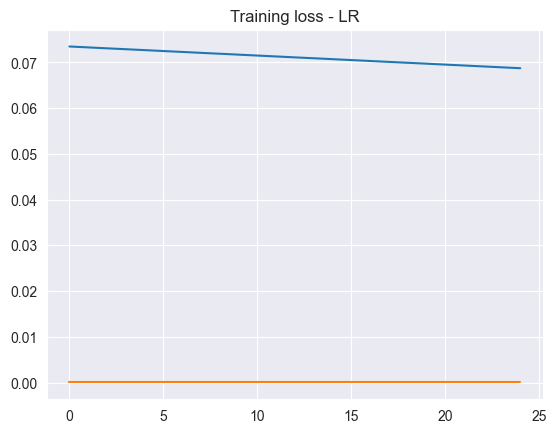

In [33]:
loss = history.history['loss']
lr = history.history['lr']
epochs = range(len(loss))
plt.plot(epochs, loss)
plt.plot(epochs, lr)
plt.title('Training loss - LR')

In [38]:
model = tf.keras.models.load_model('E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/Model/model.h5')
pred = []
first_eval_batch = scaled_train[-30:]
current_batch = first_eval_batch.reshape((1,30,1))

for i in range(30):
    current_pred = model.predict(current_batch)[0]
    pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [39]:
tes_res = test_data.loc[(test_data['material']==11000267)].copy().reset_index(drop=True)
tes_res = tes_res.groupby(['date']).sum()
tes_res = tes_res.drop(['material', 'sale_qty'], axis=1)
tes_res = tes_res.reset_index()
tes_res = tes_res[-30:]
tes_res['pred_sale'] = pred
tes_res['pred_sale'] = tes_res['pred_sale'].astype(np.float64)
tes_res['sale_qty'] = scaled_test[-30:]
tes_res

,date,pred_sale,sale_qty
1,2021-04-12,0.087443,0.000000
2,2021-04-13,0.125870,0.000000
3,2021-04-14,0.119423,0.016129
4,2021-04-15,0.133706,0.000000
5,2021-04-16,0.128523,0.483871
6,2021-04-17,0.111957,0.080645
7,2021-04-18,0.101061,0.096774
8,2021-04-19,0.100223,0.000000
9,2021-04-20,0.105681,0.016129
10,2021-04-21,0.109916,0.016129


In [40]:
predicted_sales_sc = go.Scatter(x=tes_res['date'], y=tes_res['pred_sale'], name='Predicted')
actual_sales_sc = go.Scatter(x=tes_res['date'], y=tes_res['sale_qty'], name='Actual')
layout = go.Layout(title='Test', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[actual_sales_sc, predicted_sales_sc], layout=layout)
iplot(fig)

In [41]:
# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(scaled_train[-30:], pred))
print("RMSE: ", rmse)
mse = mean_squared_error(scaled_train[-30:], pred)
print("MSE: ", mse)
mae = mean_absolute_error(scaled_train[-30:], pred)
print("MAE: ", mae)
mpe = mean_absolute_percentage_error(scaled_train[-30:], pred)
print("MPE", mpe)

RMSE:  0.14534663396163833
MSE:  0.02112564400397848
MAE:  0.12026717656402178
MPE 316939532780613.25


RMSE:  0.13260751295986506
MSE:  0.017584752493400777
MAE:  0.07265098402577061
MPE 140378232236715.03

RMSE:  0.13239336466791987
MSE:  0.017528003008092815
MAE:  0.07560938494580408
MPE 151482466408858.0

In [13]:
tf.keras.models.save_model(model, 'E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/Model/model.h5')

# Training

In [33]:
material_list = pd.read_csv('E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/material_list.csv')
material_list = material_list.drop(['material_desc'],axis=1)
material_list['material'] = material_list['material'].astype(np.int64)
material_list = material_list[68:]
material_list

,Unnamed: 0,material
68,68,11000113
69,69,11000115
70,70,11000116
71,71,11000117
72,72,11000118
...,...,...
544,544,11002173
545,545,11002174
546,546,11002182
547,547,11002198


material_list['material'] = ['11000002',
                             '11000008',
                             '11000009',
                             '11000025',
                             '11000082',
                             '11000146',
                             '11000188',
                             '11000192',
                             '11000219',
                             '11000220',
                             '11000222',
                             '11000241',
                             '11000251',
                             '11000257',
                             '11000267',
                             '11000288',
                             '11000298',
                             '11000302',
                             '11000303',
                             '11000362',
                             '11000424',
                             '11000485',
                             '11000487',
                             '11000501',
                             '11000502',
                             '11000684',
                             '11001044',
                             '11001296'
                             '11001655',
                             '11001657',
                             '11001658',
                             '11001741',
                             '11002020']

In [17]:
model = tf.keras.models.load_model('E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/Model/model.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            30200     
                                                                 
 lstm_2 (LSTM)               (None, 10)                2440      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 73,451
Trainable params: 73,451
Non-trainable p

In [34]:
for i in material_list['material'].unique():
    data_train = train_data.loc[(train_data['material']==i)].copy()
    data_train = data_train.drop(['material','date'],axis=1)
    print('Material_ID :', i)
    if data_train['sale_qty'].count() > 30:
        train = data_train
        scaler = MinMaxScaler()
        scaler.fit(train)
        scaled_train = scaler.transform(train)
        n_input = 30
        n_feature = 1
        batch_size = 1
        generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size=batch_size)
        model = tf.keras.models.load_model('E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/Model/model.h5')
        model.compile(loss=huber_loss, optimizer = keras.optimizers.Adam(1e-5))
        model.fit(generator, epochs = 50, callbacks=[lrdecay])
        tf.keras.models.save_model(model, 'E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/Model/model.h5')
    else:
        print('Data Tidak Mencukupi. Skiping.....')

Material_ID : 11000113
Epoch 1/50
115/115 [==============================] - 5s 12ms/step - loss: 0.0147 - lr: 0.0010
Epoch 2/50
115/115 [==============================] - 1s 9ms/step - loss: 0.0135 - lr: 0.0010
Epoch 3/50
115/115 [==============================] - 1s 9ms/step - loss: 0.0131 - lr: 0.0010
Epoch 4/50
115/115 [==============================] - 1s 9ms/step - loss: 0.0130 - lr: 0.0010
Epoch 5/50
115/115 [==============================] - 1s 9ms/step - loss: 0.0128 - lr: 0.0010
Epoch 6/50
115/115 [==============================] - 1s 9ms/step - loss: 0.0127 - lr: 0.0010
Epoch 7/50
115/115 [==============================] - 1s 10ms/step - loss: 0.0125 - lr: 0.0010
Epoch 8/50
115/115 [==============================] - 1s 10ms/step - loss: 0.0123 - lr: 0.0010
Epoch 9/50
115/115 [==============================] - 1s 9ms/step - loss: 0.0118 - lr: 0.0010
Epoch 10/50
115/115 [==============================] - 1s 9ms/step - loss: 0.0118 - lr: 0.0010
Epoch 11/50
115/115 [============

KeyboardInterrupt: 

In [35]:
tf.keras.models.save_model(model, 'E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/Model/model.h5')